# Bài tập thực hành Biến hình và xử lý ảnh 01
# MSSV: 18110014 - Họ tên: Nguyễn Phú Thành

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
from PIL import Image

In [2]:
def imShows(Images, Labels = None, rows = 1, cols = 1):
    imagesArray = list(Images)
    labelsArray = [f"Image {i + 1}" for i in range(len(imagesArray))] if Labels is None else list(Labels)
    figsize = (14, 12) if ((rows == 1) and (cols == 1)) else (cols * 8, rows * 5)
    fig = plt.figure(figsize = figsize)
    for i in range(1, rows * cols + 1):
        ax = fig.add_subplot(rows, cols, i)
        image = imagesArray[i - 1]
        cmap = plt.cm.gray if (len(image.shape) < 3) else None
        ax.imshow(image, cmap = cmap)
        ax.set(title = labelsArray[i - 1], xticks = [], yticks = [])
    plt.show()

In [3]:
def fromDirectory(path, extension = '.jpg'):
    current_path = os.getcwd()
    os.chdir(path)
    
    image_dicts = dict()
    
    for file in os.listdir():
        if file.endswith(extension):
            image_dicts.setdefault(file, 0)
            if extension == '.png':
                with Image.open(file) as img:
                    image_dicts[file] = np.asarray(img.convert('RGB'))
            else:
                image_dicts[file] = plt.imread(file)
    os.chdir(current_path)
    return image_dicts

In [4]:
image_dicts = dict()

for ext in ['.jpg', '.jpeg', '.png']:
    imgs = fromDirectory('Object Segmentation Data', extension = ext)
    image_dicts.update(imgs)

In [5]:
def createMaskFromThresh(imgGray, thres, lower = 0, upper = 255, left_background = True):
    
    assert (thres >= lower) and (thres <= upper), 'thres value must between lower bound and upper bound'
    
    mask = np.zeros(imgGray.shape, dtype = imgGray.dtype)
    
    if left_background:
        mask[(imgGray > thres) & (imgGray <= upper)] = 1
    else:
        mask[(imgGray < thres) & (imgGray >= lower)] = 1
    return mask

In [6]:
def segmentFromMask(img, mask, mask_val = 1):
    if len(img.shape) == 2:
        return np.where(mask == mask_val, img, 0)
    else:
        result_segment = np.zeros(img.shape, dtype = img.dtype)
        for channel in range(len(img.shape)):
            result_segment[:, :, channel] = np.where(mask == mask_val, img[:, :, channel], 0)
        return result_segment

In [7]:
def gammaEnhancedment(imgGray, gamma = 1, gain = 1):
    float_img = imgGray.astype(np.float32)/255.0
    enhanced_img = gain * float_img**gamma
    
    return (255.0 * enhanced_img).astype(np.uint8)

# 1/ Thực hiện tốt hơn việc segmentation bàn tay với các phần xương, da, và background bằng các thuật toán global và local threshoding như trong file hướng dẫn

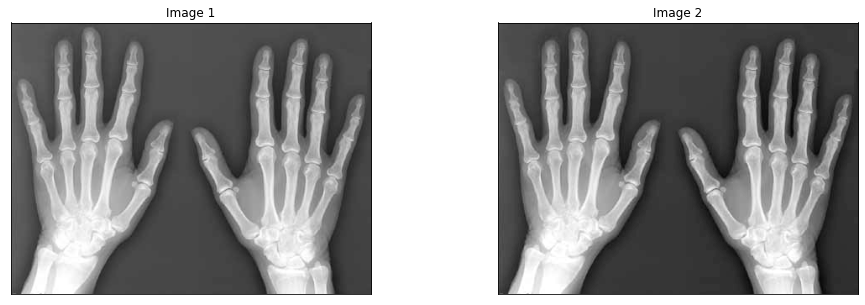

In [8]:
img_orig = image_dicts['Hand.jpg']
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
imShows([img_orig, img_gray], rows = 1, cols = 2)

In [9]:
def pTileMethod(imgGray, p, dark_fg = True):
    histogram, _ = np.histogram(imgGray.flatten(), bins = 256, range = (0, 256))
    cumulative_hist = np.cumsum(histogram)
    cumulative_freq = cumulative_hist/cumulative_hist[-1]
    
    if dark_fg:
        T = np.searchsorted(cumulative_freq, [p, ], side = 'right')[0]
    else:
        T = np.searchsorted(cumulative_freq, [1 - p, ], side = 'right')[0]
    return T

In [10]:
def otsuThreshold(grayImg):
    inputImg = grayImg
    
    flatten_input = inputImg.flatten()
    flatten_shape = flatten_input.shape[0]
    
    histogram, bins = np.histogram(flatten_input, bins = 256, range = (0, 256))[:2]
    
    bins = bins.astype(np.int16)
    
    frequency = histogram/flatten_shape
    
    mu = np.sum(bins[:-1] * frequency)
    
    # Initialize at t = 0: q1(0) = P(0), mu_1(0) = 0, mu_2(0) = mu - mu_1(0) = mu
    q_1, mu_1, mu_2 = frequency[0], 0, mu
    
    # Placeholder for threshold T and initialize between class variance at t = 0
    maximize_T, maximize_var = 0, q_1 * (1 - q_1) * (mu_1 - mu_2)**2
    
    for i in range(0, 255):
        # Get P(t + 1)
        freq = frequency[i + 1]
        
        # q1(t + 1) = q1(t) + P(t + 1)
        next_q1 = q_1 + frequency[i + 1]
    
        if next_q1 != 0 and next_q1 != 1:
            # mu_1(t + 1) = (q1(t) * mu_1(t) + (t + 1) * P(t + 1))/q1(t + 1)
            mu_1 = (q_1 * mu_1 + (i + 1) * freq)/next_q1
            # mu_2 = (mu - q1(t + 1) * mu_1(t + 1))/(1 - q1(t + 1)) 
            mu_2 = (mu - next_q1 * mu_1)/(1 - next_q1)
            
            # Set new q1
            q_1 = next_q1
            
            # Calculate between class variance
            betweenClassVariance = q_1 * (1 - q_1) * (mu_1 - mu_2)**2
            
            if betweenClassVariance > maximize_var:
                maximize_T = i + 1
                maximize_var = betweenClassVariance
    
    return maximize_T

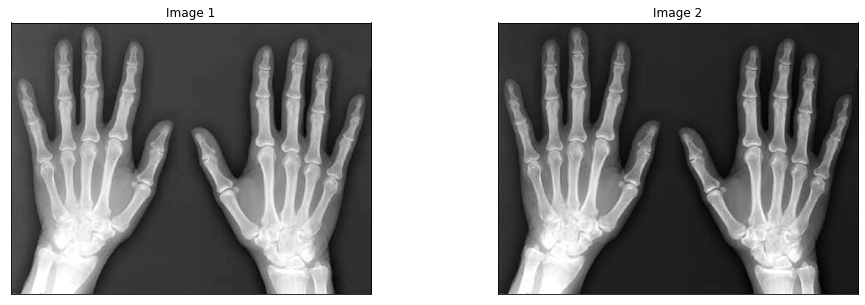

In [11]:
enhanced_img = gammaEnhancedment(img_gray, gamma = 1.5)
imShows([img_gray, enhanced_img], rows = 1, cols = 2)

In [12]:
p_hands, p_bones = 0.56, 0.78
thres_hands, thres_bones = pTileMethod(enhanced_img, p_hands), pTileMethod(enhanced_img, p_bones)
mask_hands, mask_bones = createMaskFromThresh(enhanced_img, thres_hands), createMaskFromThresh(enhanced_img, thres_bones)

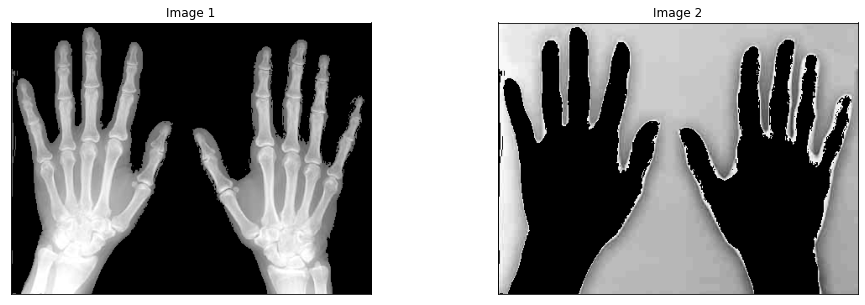

In [13]:
hands = segmentFromMask(img_gray, mask_hands)
background = segmentFromMask(img_gray, mask_hands, mask_val = 0)

imShows([hands, background], rows = 1, cols = 2)

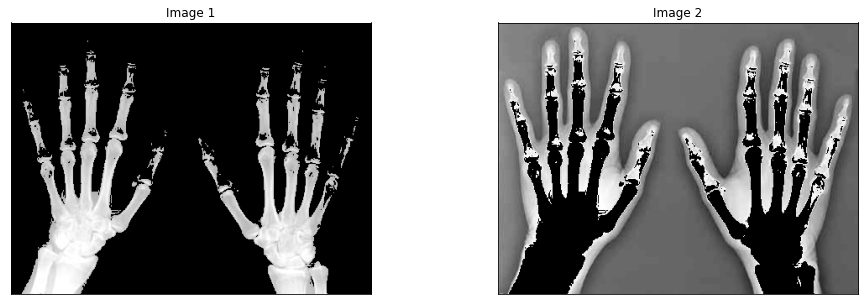

In [14]:
bones = segmentFromMask(img_gray, mask_bones)
background = segmentFromMask(img_gray, mask_bones, mask_val = 0)

imShows([bones, background], rows = 1, cols = 2)

# 2/ Chọn thêm 2 ví dụ trong danh sách hình và định nghĩa object cần segment trong các hình là gì và thực hiện segmentation tốt nhất bằng global và local thresholding 

In [15]:
def pixelTransformation(pix, old_low, old_upper, new_low, new_upper):
    if 0 <= pix < old_low:
        return pix/old_low * new_low
    elif old_low <= pix <= old_upper:
        return (pix - old_low)/(old_upper - old_low) * (new_upper - new_low) + new_low
    else:
        return (pix - old_upper)/(255 - old_upper) * (255 - new_upper) + new_upper

def contrastStretching(img, old_low, old_upper, new_low, new_upper):
    return np.vectorize(pixelTransformation)(img, old_low, old_upper, new_low, new_upper)

## Leaf.jpg

## Object cần segment: Phần lá của bức ảnh

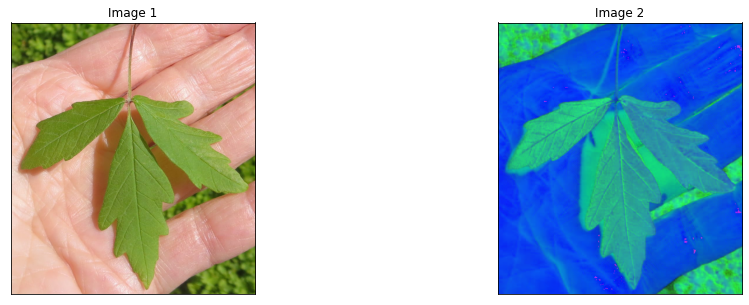

In [16]:
img_orig = image_dicts['Leaf.jpg']
img_hsv = cv2.cvtColor(img_orig, cv2.COLOR_RGB2HSV)
imShows([img_orig, img_hsv], rows = 1, cols = 2)

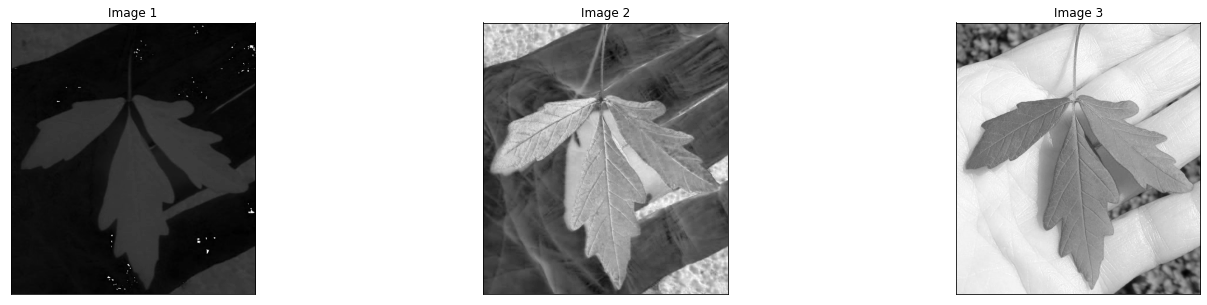

In [17]:
imShows([img_hsv[:, :, i] for i in [0, 1, 2]], rows = 1, cols = 3)

In [18]:
hue_img = img_hsv[:, :, 0]

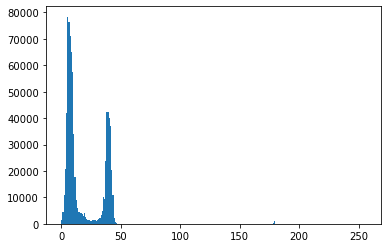

In [19]:
_ = plt.hist(hue_img.flatten(), bins = 256, range = (0, 256))

In [20]:
contrast_hue = contrastStretching(hue_img, 0, 50, 0, 255)

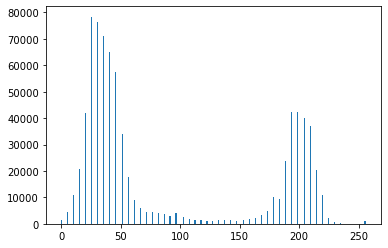

In [21]:
_ = plt.hist(contrast_hue.flatten(), bins = 256, range = (0, 256))

In [22]:
T = otsuThreshold(contrast_hue)

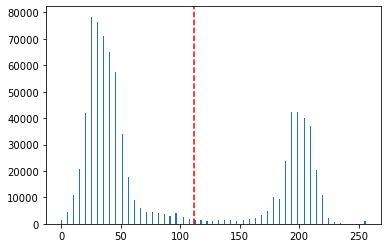

In [23]:
fig, ax = plt.subplots()
_ = ax.hist(contrast_hue.flatten(), bins = 256, range = (0, 256))
ax.axvline(T, color = 'red', linestyle = 'dashed')

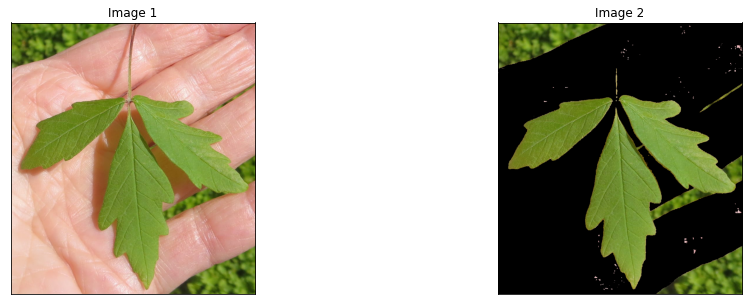

In [24]:
mask = createMaskFromThresh(contrast_hue, T)
leaf = segmentFromMask(img_orig, mask)
imShows([img_orig, leaf], rows = 1, cols = 2)

## Writing.jpg

## Object cần segment: Các từ trong bức ảnh

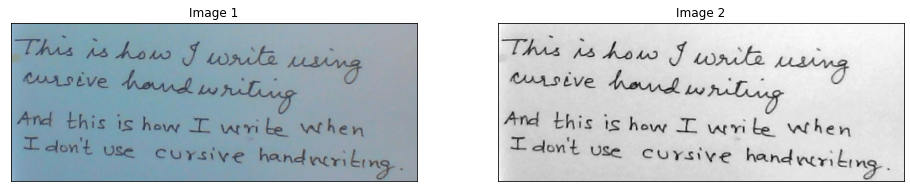

In [25]:
img_orig = image_dicts['Writing.png']
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
imShows([img_orig, img_gray], rows = 1, cols = 2)

In [26]:
from skimage.filters import threshold_sauvola

In [27]:
thresh_sauvola = threshold_sauvola(img_gray, window_size = 25, k = 0.2, r = 125)
mask = (img_gray <= thresh_sauvola)

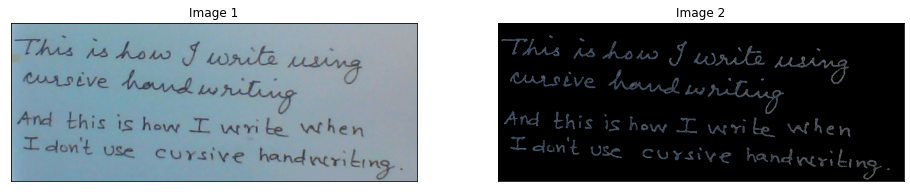

In [28]:
handwriting = segmentFromMask(img_orig, mask)
imShows([img_orig, handwriting], rows = 1, cols = 2)

## Bone.jpg

## Object cần segment: Vết nứt/gãy của xương tay

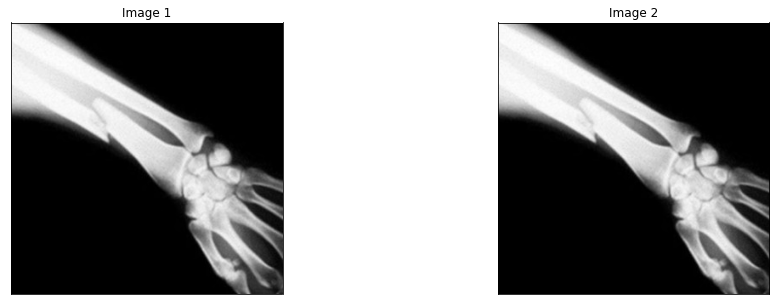

In [29]:
img_orig = image_dicts['Bone.jpg']
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
imShows([img_orig, img_gray], rows = 1, cols = 2)

In [30]:
clahe = cv2.createCLAHE(clipLimit = 35, tileGridSize = (7, 6))
cl1 = clahe.apply(img_gray)

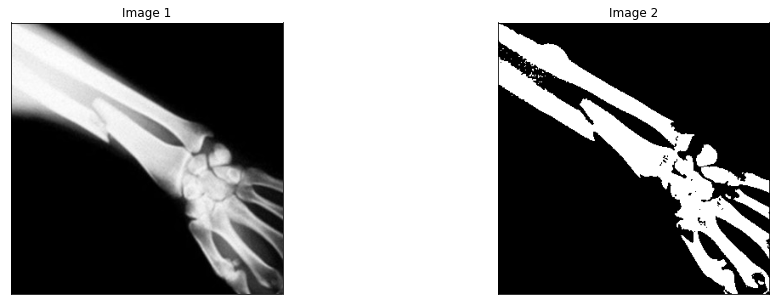

In [31]:
T = pTileMethod(cl1, 0.78)
mask = createMaskFromThresh(cl1, T)
imShows([img_gray, mask], rows = 1, cols = 2)

In [32]:
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3)))

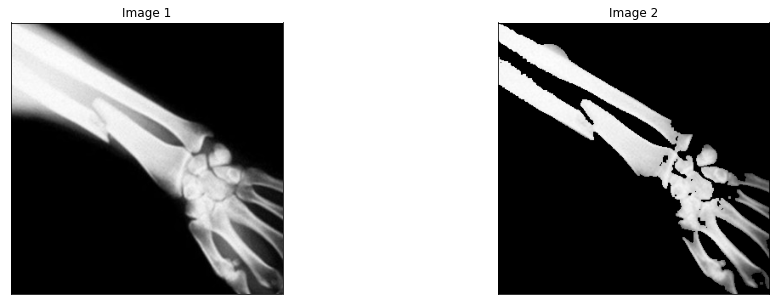

In [33]:
bone = segmentFromMask(img_orig, mask)
imShows([img_orig, bone], rows = 1, cols = 2)

## Gesture.jpg

## Object cần segment: Bàn tay

In [34]:
def splitMaskByAxis(mask, splitters, axis = 0):
    rows, cols = mask.shape
    result_regions = np.zeros(mask.shape, dtype = mask.dtype)
    if axis == 0: # Split by rows
        left = 0
        for i, right in enumerate(splitters):
            result_regions[left:right, :] = np.where(mask[left:right, :] == 1, i + 1, 0)
            left = right
        i += 1
        result_regions[left:, :] = np.where(mask[left:, :] == 1, i + 1, 0)
        return result_regions
    elif axis == 1: # Split in columns
        left = 0
        for i, right in enumerate(splitters):
            result_regions[:, left:right] = np.where(mask[:, left:right] == 1, i + 1, 0)
            left = right
        i += 1
        result_regions[:, left:] = np.where(mask[:, left:] == 1, i + 1, 0)
        return result_regions
    else:
        raise ValueError('Axis value must be 0 or 1')

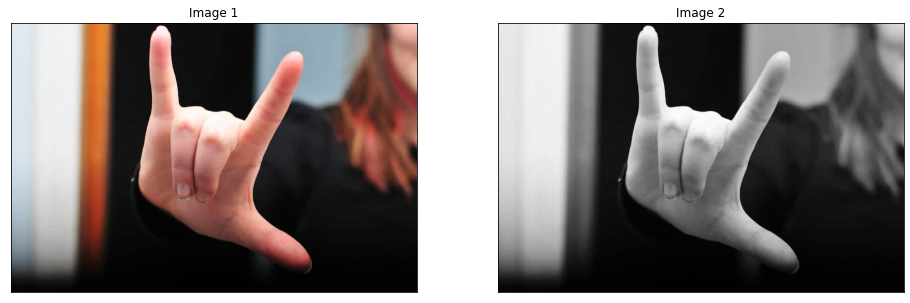

In [35]:
img_orig = image_dicts['Gesture.jpg']
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_ycrcb = cv2.cvtColor(img_orig, cv2.COLOR_RGB2YCR_CB)
imShows([img_orig, img_gray], rows = 1, cols = 2)

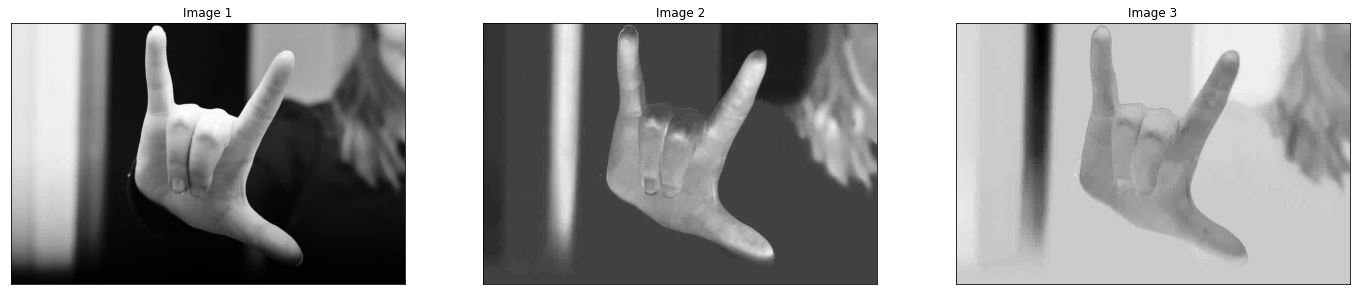

In [36]:
imShows([img_ycrcb[:, :, i] for i in [0, 1, 2]], rows = 1, cols = 3)

In [37]:
secondChannel_img = img_ycrcb[:, :, 1].copy()

In [38]:
T = pTileMethod(secondChannel_img, 0.6)
mask = createMaskFromThresh(secondChannel_img, T)

In [39]:
regions = splitMaskByAxis(mask, [210, 600], axis = 1)

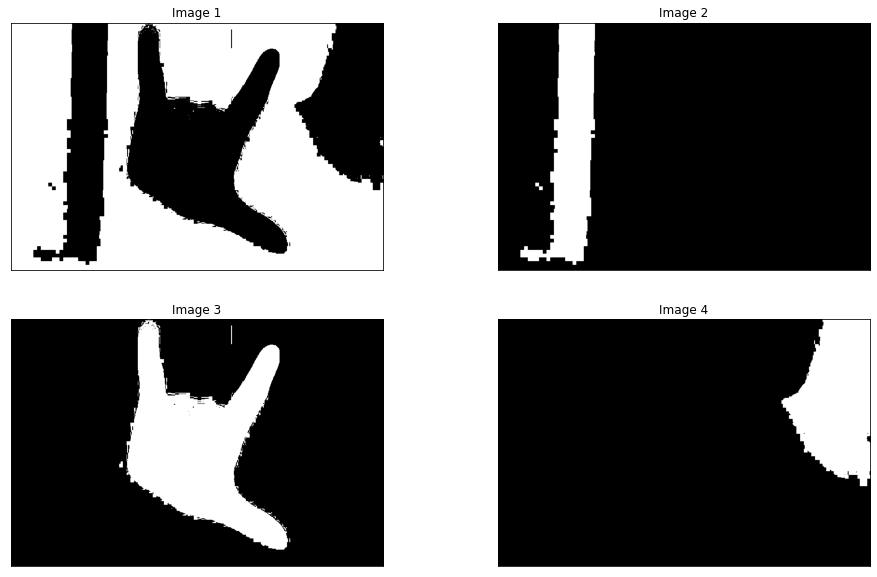

In [40]:
imShows([(regions == i) for i in np.unique(regions)], rows = 2, cols = 2)

In [41]:
mask = (regions == 2).astype(np.uint8)

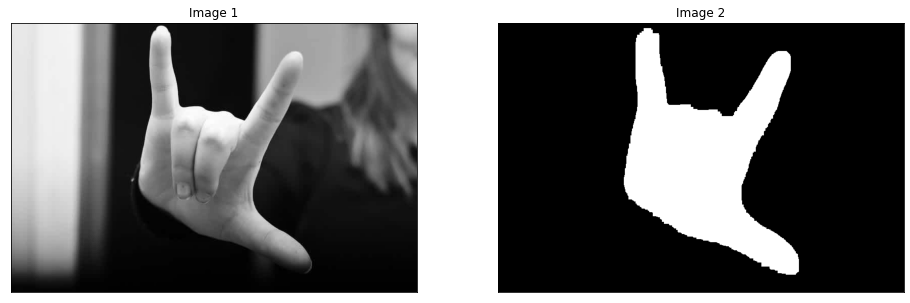

In [42]:
mask = cv2.erode(
    cv2.dilate(
        cv2.erode(mask, np.ones((5,5)), iterations = 2),
        np.ones((7, 7)),
        iterations = 5
    ),
    np.ones((5,5)),
    iterations = 5
)

imShows([img_gray, mask], rows = 1, cols = 2)

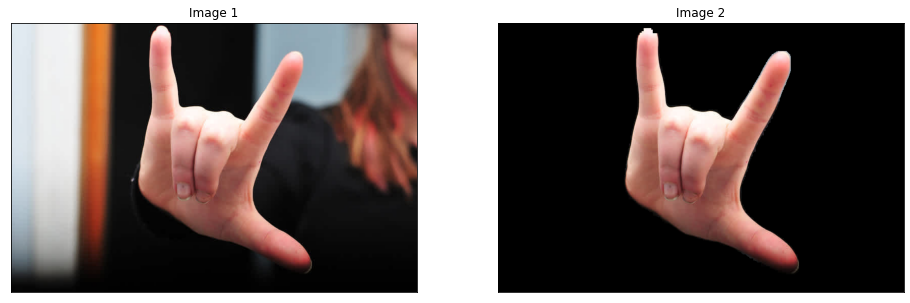

In [43]:
gesture = segmentFromMask(img_orig, mask)
imShows([img_orig, gesture], rows = 1, cols = 2)

## Crack.jpg

## Object cần segment: Vết nứt trong bức ảnh

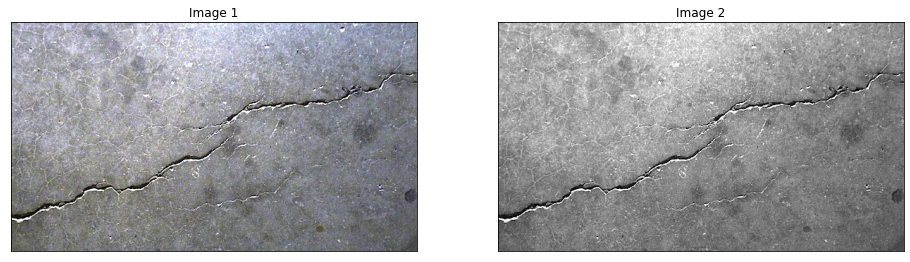

In [44]:
img_orig = image_dicts['Crack.jpg']
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_hsv = cv2.cvtColor(img_orig, cv2.COLOR_RGB2HSV)
imShows([img_orig, img_gray],rows = 1, cols = 2)

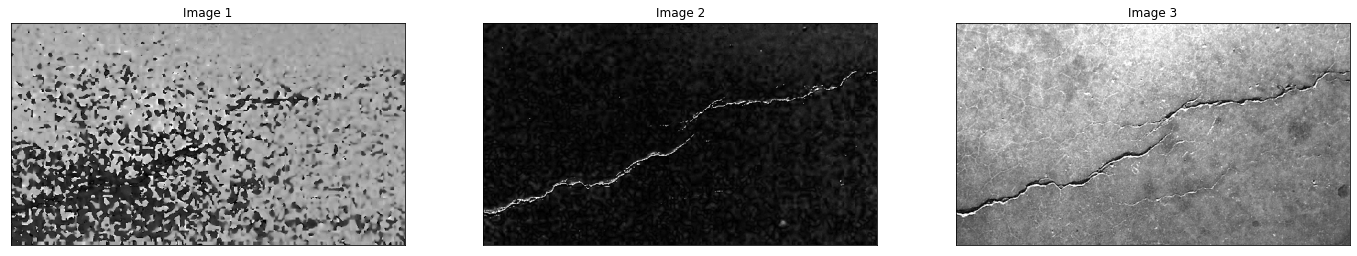

In [45]:
imShows([img_hsv[:,  :, i] for i in [0, 1, 2]], rows = 1, cols = 3)

In [46]:
saturation_img = img_hsv[:, :, 1]

In [47]:
T = otsuThreshold(saturation_img)
mask = createMaskFromThresh(saturation_img, T)

In [48]:
mask = cv2.erode(
    cv2.dilate(
        mask,
        np.ones((3, 3)),
        iterations = 4
    ),
    np.ones((4, 3)),
    iterations = 3
)

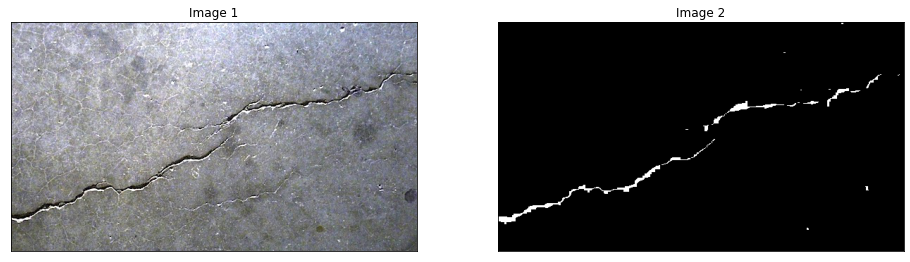

In [49]:
imShows([img_orig, mask], rows = 1, cols = 2)